# Gene naming mapping


This notebook reviews the intersection between gene names used in the following files:
1. HGNC table
2. CellXGene Census
3. Ensemble's list

It explores their intersection of protein-coding genes and their expression rates. 

The effort is done to help conclude what should be our gold-standard genes list that would later affect tokenization.

In [1]:
import random
from io import StringIO
from itertools import combinations

import numpy as np
import pandas as pd
import requests
import seaborn as sns
import torch
from upsetplot import plot


def look_for_duplicate_entries(df, col_name):
    df[col_name] = df[col_name].str.upper()
    duplicates = df[df.duplicated(subset=col_name)]
    return print(duplicates)


def find_rows_with_string(df, search_string):
    mask = df.apply(lambda row: row.astype(str).str.contains(search_string, case=False, na=False)).any(axis=1)
    return df[mask]


def find_and_print_matched_substring(df, string_list):
    all_values = df.astype(str).values.flatten()
    found_substrings = set()

    for substring in string_list:
        if any(substring in value for value in all_values):
            found_substrings.add(substring)
            print(f"Found substring: '{substring}'")

    if not found_substrings:
        print("No matches found in the dataframe.")


## Review the HGNC table

In [2]:
hgnc_url = 'https://storage.googleapis.com/public-download-files/hgnc/archive/archive/monthly/tsv/hgnc_complete_set_2024-08-23.txt'

response = requests.get(hgnc_url)
hgnc_raw = response.text
hgnc_io = StringIO(hgnc_raw)
hgnc = pd.read_csv(hgnc_io, sep='\t')
hgnc = pd.DataFrame(hgnc)

/tmp/ipykernel_3200922/2854162589.py:6: DtypeWarning: Columns (32,34,38,40,50) have mixed types. Specify dtype option on import or set low_memory=False.
  hgnc = pd.read_csv(hgnc_io, sep='\t')


The HGNC table holds multiple name entries for each gene as shown below:

In [3]:
hgnc.head().transpose()

,0,1,2,3,4
hgnc_id,HGNC:5,HGNC:37133,HGNC:24086,HGNC:7,HGNC:27057
symbol,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1
name,alpha-1-B glycoprotein,A1BG antisense RNA 1,APOBEC1 complementation factor,alpha-2-macroglobulin,A2M antisense RNA 1
locus_group,protein-coding gene,non-coding RNA,protein-coding gene,protein-coding gene,non-coding RNA
locus_type,gene with protein product,"RNA, long non-coding",gene with protein product,gene with protein product,"RNA, long non-coding"
status,Approved,Approved,Approved,Approved,Approved
location,19q13.43,19q13.43,10q11.23,12p13.31,12p13.31
location_sortable,19q13.43,19q13.43,10q11.23,12p13.31,12p13.31
alias_symbol,NaN,FLJ23569,ACF|ASP|ACF64|ACF65|APOBEC1CF,FWP007|S863-7|CPAMD5,NaN
alias_name,NaN,NaN,NaN,NaN,NaN


Review missing values in table:

In [4]:
hgnc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43873 entries, 0 to 43872
Data columns (total 54 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   hgnc_id                   43873 non-null  object 
 1   symbol                    43873 non-null  object 
 2   name                      43873 non-null  object 
 3   locus_group               43873 non-null  object 
 4   locus_type                43873 non-null  object 
 5   status                    43873 non-null  object 
 6   location                  43873 non-null  object 
 7   location_sortable         43873 non-null  object 
 8   alias_symbol              22359 non-null  object 
 9   alias_name                7585 non-null   object 
 10  prev_symbol               12473 non-null  object 
 11  prev_name                 22837 non-null  object 
 12  gene_group                25872 non-null  object 
 13  gene_group_id             25872 non-null  object 
 14  date_a

In [5]:
hgnc_crosstab = pd.crosstab(hgnc['locus_group'], 
                            hgnc['status'],  
                               margins = False) 
print(hgnc_crosstab) 

status               Approved
locus_group                  
non-coding RNA           9114
other                     999
protein-coding gene     19283
pseudogene              14477


From now on will concentrate in the "protein-coding genes"

In [6]:
hgnc_protein_coding = hgnc.loc[hgnc['locus_group'] == 'protein-coding gene']

 ## Compare HGNC protein-coding genes list to Ensemble's list


In [7]:
ensemble_list = torch.load("/dccstor/bmfm-targets/data/omics/proteins/release-112/data/Homo_sapiens.GRCh38.pep.all.gene_symbol_to_embedding_ESM1b.pt")
ensemble_df = pd.DataFrame(ensemble_list)

In [8]:
common_genes_hgnc_ensemble = list(set(hgnc_protein_coding.symbol) & set(ensemble_df.columns.values))
print(f"""Common genes of hgnc and Ensemble's list :{len(common_genes_hgnc_ensemble)} out of {hgnc_protein_coding.shape[0]} ({round((100 * len(common_genes_hgnc_ensemble) / hgnc_protein_coding.shape[0]), 2)}%) hgnc protein-coding genes 
      and {ensemble_df.shape[1]} ({round(100 * len(common_genes_hgnc_ensemble) / ensemble_df.shape[1], 2)}%) in Ensemble's list""")

Common genes of hgnc and Ensemble's list :19186 out of 19283 (99.5%) hgnc protein-coding genes 
      and 19825 (96.78%) in Ensemble's list


In [9]:
non_common_genes_hgnc_ensemble = list(set(hgnc_protein_coding.symbol) ^ set(ensemble_df.columns.values))
print(f"{len(non_common_genes_hgnc_ensemble)} genes does not overlap between HGNC and Ensemble's list.")

736 genes does not overlap between HGNC and Ensemble's list.


In [10]:
hgnc_non_coding_genes = hgnc.loc[hgnc['locus_group'] != 'protein-coding gene']
common_hgnc_non_coding_genes_w_ensemble_list = list(set(hgnc_non_coding_genes.symbol) & set(ensemble_df.columns.values))
print(f"{len(common_hgnc_non_coding_genes_w_ensemble_list)} genes from Ensemble's list present in HGNC but not as protein-coding genes")

619 genes from Ensemble's list present in HGNC but not as protein-coding genes


How does the genes from Ensemble's list that aren't classified as protein-coding genes in hgnc are classified:

In [11]:

tab_common_hgnc_non_coding_genes_w_ensemble_list = hgnc.loc[hgnc['symbol'].isin(common_hgnc_non_coding_genes_w_ensemble_list)]
common_hgnc_non_coding_genes_w_ensemble_crosstab = pd.crosstab(tab_common_hgnc_non_coding_genes_w_ensemble_list['locus_group'], 
                            tab_common_hgnc_non_coding_genes_w_ensemble_list['status'],
                               margins = False) 
print(common_hgnc_non_coding_genes_w_ensemble_crosstab) 

status          Approved
locus_group             
non-coding RNA         7
other                588
pseudogene            24


The genes that are classified as "non-coding RNA" from Ensemble's list:

In [12]:

tab_common_hgnc_non_coding_genes_w_ensemble_list.loc[tab_common_hgnc_non_coding_genes_w_ensemble_list['locus_group'] == 'non-coding RNA']

,hgnc_id,symbol,name,locus_group,locus_type,status,location,location_sortable,alias_symbol,alias_name,...,cd,lncrnadb,enzyme_id,intermediate_filament_db,rna_central_ids,lncipedia,gtrnadb,agr,mane_select,gencc
13771,HGNC:49147,KBTBD11-OT1,KBTBD11 overlapping transcript 1,non-coding RNA,"RNA, long non-coding",Approved,8p23.3,08p23.3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,KBTBD11-OT1,NaN,HGNC:49147,NaN,NaN
15856,HGNC:21195,LINC01556,long intergenic non-protein coding RNA 1556,non-coding RNA,"RNA, long non-coding",Approved,6p22.1,06p22.1,dJ25J6.5,NaN,...,NaN,NaN,NaN,NaN,NaN,LINC01556,NaN,HGNC:21195,NaN,NaN
16459,HGNC:53069,LINC02203,long intergenic non-protein coding RNA 2203,non-coding RNA,"RNA, long non-coding",Approved,15q11.2,15q11.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:53069,NaN,NaN
16474,HGNC:53085,LINC02218,long intergenic non-protein coding RNA 2218,non-coding RNA,"RNA, long non-coding",Approved,5p15.1,05p15.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:53085,NaN,NaN
23910,HGNC:56199,OR4M2-OT1,OR4M2 overlapping transcript 1,non-coding RNA,"RNA, long non-coding",Approved,15q11.2,15q11.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36360,HGNC:19078,SNHG32,small nucleolar RNA host gene 32,non-coding RNA,"RNA, long non-coding",Approved,6p21.33,06p21.33,D6S57|G8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:19078,NaN,NaN
41278,HGNC:44088,TUNAR,TCL1 upstream neural differentiation-associate...,non-coding RNA,"RNA, long non-coding",Approved,14q32.2,14q32.2,TUNA|HI-LNC78|BNLN,Tcl1 upstream neuron-associated lincRNA|Human ...,...,NaN,NaN,NaN,NaN,NaN,TUNAR,NaN,HGNC:44088,ENST00000503525.3|NM_001416131.1,NaN


The genes that are classified as "pseudogene" from Ensemble's list:

In [13]:

tab_common_hgnc_non_coding_genes_w_ensemble_list.loc[tab_common_hgnc_non_coding_genes_w_ensemble_list['locus_group'] == 'pseudogene']

,hgnc_id,symbol,name,locus_group,locus_type,status,location,location_sortable,alias_symbol,alias_name,...,cd,lncrnadb,enzyme_id,intermediate_filament_db,rna_central_ids,lncipedia,gtrnadb,agr,mane_select,gencc
747,HGNC:21596,AK4P3,adenylate kinase 4 pseudogene 3,pseudogene,pseudogene,Approved,12p11.21,12p11.21,AK3L2P,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:21596,NaN,NaN
6462,HGNC:30838,DEFB109D,defensin beta 109D (pseudogene),pseudogene,pseudogene,Approved,8p23.1,08p23.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:30838,NaN,NaN
7247,HGNC:38670,DUX4L8,double homeobox 4 like 8 (pseudogene),pseudogene,pseudogene,Approved,4q35.2,04q35.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:38670,NaN,NaN
8679,HGNC:43617,FAM90A27P,"family with sequence similarity 90 member A27,...",pseudogene,pseudogene,Approved,19q13.42,19q13.42,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:43617,NaN,NaN
8757,HGNC:33936,FAM153CP,"family with sequence similarity 153 member C, ...",pseudogene,pseudogene,Approved,5q35.3,05q35.3,NY-REN-7-like,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:33936,NaN,NaN
10570,HGNC:32376,GOLGA8DP,"golgin A8 family member D, pseudogene",pseudogene,pseudogene,Approved,15q11.2,15q11.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:32376,NaN,NaN
11755,HGNC:4993,HMGB1P1,high mobility group box 1 pseudogene 1,pseudogene,pseudogene,Approved,20q13.31,20q13.31,HMG1L7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:4993,NaN,NaN
12856,HGNC:5633,IGHV3OR15-7,immunoglobulin heavy variable 3/OR15-7 (pseudo...,pseudogene,immunoglobulin pseudogene,Approved,15q11.2,15q11.2,IGHV3/OR15-7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14084,HGNC:16344,KIR2DP1,"killer cell immunoglobulin like receptor, two ...",pseudogene,pseudogene,Approved,19q13.42,19q13.42,KIRZ|KIRY|KIR15|KIR2DL6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:16344,NaN,NaN
14093,HGNC:16343,KIR3DP1,"killer cell immunoglobulin like receptor, thre...",pseudogene,pseudogene,Approved,19q13.42,19q13.42,KIRX|KIR48|KIR2DS6|KIR3DS2P|CD158C,NaN,...,CD158C,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:16343,NaN,NaN


In [14]:
genes_in_ensemble_not_hgnc = list(set(ensemble_df.columns.values) & set(non_common_genes_hgnc_ensemble))
random.seed(74353)
random_sample_genes_in_ensemble_not_hgnc = random.sample(genes_in_ensemble_not_hgnc, 10)
print(f"""10 random genes from Ensemble list that are not in hgnc proten-coding gene: 
      {random_sample_genes_in_ensemble_not_hgnc}""")

10 random genes from Ensemble list that are not in hgnc proten-coding gene: 
      ['TRBV6-7', 'OR5D3P', 'PCDHA2', 'IGKV1-8', 'PCDHGA10', 'TEN1-CDK3', 'IGHV2-70D', 'IGHV1OR15-1', 'PCDHB9', 'TRAV3']


In [15]:
hgnc.loc[hgnc['symbol'].isin(random_sample_genes_in_ensemble_not_hgnc)]

,hgnc_id,symbol,name,locus_group,locus_type,status,location,location_sortable,alias_symbol,alias_name,...,cd,lncrnadb,enzyme_id,intermediate_filament_db,rna_central_ids,lncipedia,gtrnadb,agr,mane_select,gencc
12785,HGNC:5563,IGHV1OR15-1,immunoglobulin heavy variable 1/OR15-1 (non-fu...,other,immunoglobulin gene,Approved,15q11.2,15q11.2,IGHV1/OR15-1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:5563,NaN,NaN
12801,HGNC:49602,IGHV2-70D,immunoglobulin heavy variable 2-70D,other,immunoglobulin gene,Approved,14q32.33,14q32.33,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:49602,NaN,NaN
12946,HGNC:5743,IGKV1-8,immunoglobulin kappa variable 1-8,other,immunoglobulin gene,Approved,2p11.2,02p11.2,IGKV18|L9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:5743,NaN,NaN
23988,HGNC:8336,OR5D3P,olfactory receptor family 5 subfamily D member...,pseudogene,pseudogene,Approved,11q11,11q11,OR11-8b|OR11-8c,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:8336,ENST00000641440.1|NM_001396059.1,NaN
24971,HGNC:8668,PCDHA2,protocadherin alpha 2,other,complex locus constituent,Approved,5q31.3,05q31.3,NaN,KIAA0345-like 12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:8668,ENST00000526136.2|NM_018905.3,NaN
24997,HGNC:8694,PCDHB9,protocadherin beta 9,other,complex locus constituent,Approved,5q31.3,05q31.3,PCDH-BETA9|PCDH3H,protocadherin-3h,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:8694,ENST00000316105.7|NM_019119.5,NaN
25018,HGNC:8697,PCDHGA10,"protocadherin gamma subfamily A, 10",other,complex locus constituent,Approved,5q31.3,05q31.3,PCDH-GAMMA-A10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:8697,ENST00000398610.3|NM_018913.3,NaN
38627,HGNC:44420,TEN1-CDK3,TEN1-CDK3 readthrough (NMD candidate),other,readthrough,Approved,17q25.1,17q25.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:44420,NaN,NaN
39940,HGNC:12128,TRAV3,T cell receptor alpha variable 3,other,T cell receptor gene,Approved,14q11.2,14q11.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:12128,NaN,NaN
40031,HGNC:12232,TRBV6-7,T cell receptor beta variable 6-7 (non-functio...,other,T cell receptor gene,Approved,7q34,07q34,TRBV67|TCRBV13S8P|TCRBV6S7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:12232,NaN,NaN


Review the PCDH genes group:

In [16]:
hgnc.loc[hgnc['symbol'].apply(lambda x: x.startswith('PCDH'))].locus_type.value_counts()

locus_type
complex locus constituent    56
gene with protein product    16
pseudogene                    6
RNA, long non-coding          6
Name: count, dtype: int64

## CellXGene Census genes

In [17]:
cellxgene_genes_var = pd.read_csv('/dccstor/bmfm-targets/data/omics/transcriptome/scRNA/pretrain/cellxgene/cellxgene_census_genes_var_frame_2024-07-01.csv')
cellxgene_genes_var.head()

,Unnamed: 0,soma_joinid,feature_id,feature_name,feature_length,nnz,n_measured_obs
0,0,0,ENSG00000000003,TSPAN6,4530,4530448,73855064
1,1,1,ENSG00000000005,TNMD,1476,236059,61201828
2,2,2,ENSG00000000419,DPM1,9276,17576462,74159149
3,3,3,ENSG00000000457,SCYL3,6883,9117322,73988868
4,4,4,ENSG00000000460,C1orf112,5970,6287794,73636201


In [18]:
common_genes_hgnc_cellxgene = list(set(hgnc.symbol) & set(cellxgene_genes_var.feature_name))
print(f"Intersection between HGNC and cellxgene: {len(common_genes_hgnc_cellxgene)}")

Intersection between HGNC and cellxgene: 40271


Checking intersection size with other columns than "symbol" in the HGNC table

In [19]:
common_genes_hgnc_cellxgene = list(set(hgnc_protein_coding.name.str.upper()) & set(cellxgene_genes_var.feature_name.str.upper()))
print(f"Intersection with column 'name': {len(common_genes_hgnc_cellxgene)}")

Intersection with column 'name': 22


In [20]:
common_genes_hgnc_cellxgene = list(set(hgnc.alias_symbol.str.upper()) & set(cellxgene_genes_var.feature_name.str.upper()))
print(f"Intersection with column 'alias_symbol': {len(common_genes_hgnc_cellxgene)}")

Intersection with column 'alias_symbol': 90


In [21]:
common_genes_hgnc_cellxgene = list(set(hgnc.prev_symbol.str.upper()) & set(cellxgene_genes_var.feature_name.str.upper()))
print(f"Intersection with column 'prev_symbol': {len(common_genes_hgnc_cellxgene)}")

Intersection with column 'prev_symbol': 181


In [22]:
common_genes_hgnc_cellxgene = list(set(hgnc.mane_select.str.upper()) & set(cellxgene_genes_var.feature_id.str.upper()))
print(f"Intersection with column 'mane_select': {len(common_genes_hgnc_cellxgene)}")

Intersection with column 'mane_select': 0


In [23]:
cellxgene_protein_coding = cellxgene_genes_var.loc[cellxgene_genes_var['feature_name'].isin(hgnc_protein_coding.symbol)]
cellxgene_protein_coding_tab = cellxgene_protein_coding[['feature_name', 'nnz']]
cellxgene_protein_coding_tab['Gene_group'] = 'HGNC protein coding'

/tmp/ipykernel_3200922/3523834284.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cellxgene_protein_coding_tab['Gene_group'] = 'HGNC protein coding'


### Review missing protein coding genes from Ensemble's list and their expression rate in CellXGene

In [24]:
missing_protein_genes_in_ensemble = {*hgnc_protein_coding.symbol} - {*ensemble_df.columns.values}
print(f"Number of protein coding genes from HGNC that are missing in the ensembl: {len(missing_protein_genes_in_ensemble)}")

Number of protein coding genes from HGNC that are missing in the ensembl: 97


In [25]:
ensemble_not_protein_coding = {*ensemble_df.columns.values} - {*hgnc_protein_coding.symbol}
print(f"Number of protein coding genes appears in the Ensembl but not in HGNC: {len(ensemble_not_protein_coding)}")

Number of protein coding genes appears in the Ensembl but not in HGNC: 639


In [26]:
cellxgene_genes_var.loc[cellxgene_genes_var['feature_name'].isin(missing_protein_genes_in_ensemble)].sort_values('nnz')

,Unnamed: 0,soma_joinid,feature_id,feature_name,feature_length,nnz,n_measured_obs
60474,60474,60474,ENSG00000286025,FAM246C,1719,51,1274370
40200,40200,40200,ENSG00000225997,OR4A8,945,117,4755728
51231,51231,51231,ENSG00000262085,OR1P1,994,123,5696394
60283,60283,60283,ENSG00000285843,SCYGR9,279,126,5323046
37379,37379,37379,ENSG00000213439,OR5AC1,925,129,8040428
33627,33627,33627,ENSG00000176290,OR4K3,947,140,6442342
46350,46350,46350,ENSG00000243641,OR13C7,959,172,7386269
49281,49281,49281,ENSG00000254658,OR8J2,2883,323,11402763
33469,33469,33469,ENSG00000142163,OR1E3,948,390,16643095
10782,10782,10782,ENSG00000163098,BIRC8,1826,430,18314219


Some of the HGNC protein-coding genes that are missing from Ensemble's list are highly expressed genes that look important. Let's see if their alias_names are in Ensemble's list.

In [27]:
hgnc_protein_coding.loc[hgnc_protein_coding['alias_symbol'].isin(ensemble_df.columns.values)]

,hgnc_id,symbol,name,locus_group,locus_type,status,location,location_sortable,alias_symbol,alias_name,...,cd,lncrnadb,enzyme_id,intermediate_filament_db,rna_central_ids,lncipedia,gtrnadb,agr,mane_select,gencc
221,HGNC:33904,ACOD1,aconitate decarboxylase 1,protein-coding gene,gene with protein product,Approved,13q22.3,13q22.3,CAD,NaN,...,NaN,NaN,4.1.1.6,NaN,NaN,NaN,NaN,HGNC:33904,ENST00000377462.6|NM_001258406.2,NaN
788,HGNC:381,AKR1B1,aldo-keto reductase family 1 member B,protein-coding gene,gene with protein product,Approved,7q33,07q33,AR,aldose reductase,...,NaN,NaN,1.1.1.21,NaN,NaN,NaN,NaN,HGNC:381,ENST00000285930.9|NM_001628.4,NaN
1230,HGNC:80,AOC1,amine oxidase copper containing 1,protein-coding gene,gene with protein product,Approved,7q36.1,07q36.1,DAO,diamine oxidase,...,NaN,NaN,1.4.3.22,NaN,NaN,NaN,NaN,HGNC:80,ENST00000360937.9|NM_001091.4,NaN
2172,HGNC:21727,B3GNTL1,"UDP-GlcNAc:betaGal beta-1,3-N-acetylglucosamin...",protein-coding gene,gene with protein product,Approved,17q25.3,17q25.3,B3GNT8,NaN,...,NaN,NaN,2.4.1.-,NaN,NaN,NaN,NaN,HGNC:21727,ENST00000320865.4|NM_001009905.3,NaN
3272,HGNC:16018,CADPS2,calcium dependent secretion activator 2,protein-coding gene,gene with protein product,Approved,7q31.32,07q31.32,CAPS2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:16018,ENST00000449022.7|NM_017954.11,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39633,HGNC:20161,TOX4,TOX high mobility group box family member 4,protein-coding gene,gene with protein product,Approved,14q11.2,14q11.2,LCP1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:20161,ENST00000448790.7|NM_014828.4,NaN
41589,HGNC:25205,UCMA,upper zone of growth plate and cartilage matri...,protein-coding gene,gene with protein product,Approved,10p13,10p13,GRP,Gla-rich protein,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:25205,ENST00000378681.8|NM_145314.3,NaN
41633,HGNC:12553,UGT2B4,UDP glucuronosyltransferase family 2 member B4,protein-coding gene,gene with protein product,Approved,4q13.3,04q13.3,UGT2B11,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:12553,ENST00000305107.7|NM_021139.3,NaN
41883,HGNC:12620,USP21,ubiquitin specific peptidase 21,protein-coding gene,gene with protein product,Approved,1q23.3,01q23.3,USP16,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HGNC:12620,ENST00000368002.8|NM_001014443.3,NaN


Review nnz values (non-zero entries) across the different lists according to their rate as recorded in the cellxgene Census:

In [28]:
cellxgene_non_protein_coding = cellxgene_genes_var.loc[~cellxgene_genes_var['feature_name'].isin(hgnc_protein_coding.symbol)]
cellxgene_non_protein_coding = cellxgene_non_protein_coding[['feature_name', 'nnz']]
cellxgene_non_protein_coding['Gene_group'] = 'HGNC non protein coding'

In [29]:
cellxgene_from_ensemble_list = cellxgene_genes_var.loc[cellxgene_genes_var['feature_name'].isin(ensemble_list)]
cellxgene_from_ensemble_list = cellxgene_from_ensemble_list[['feature_name', 'nnz']]
cellxgene_from_ensemble_list['Gene_group'] = "Ensemble's list"

<Axes: xlabel='log10_nnz', ylabel='Density'>

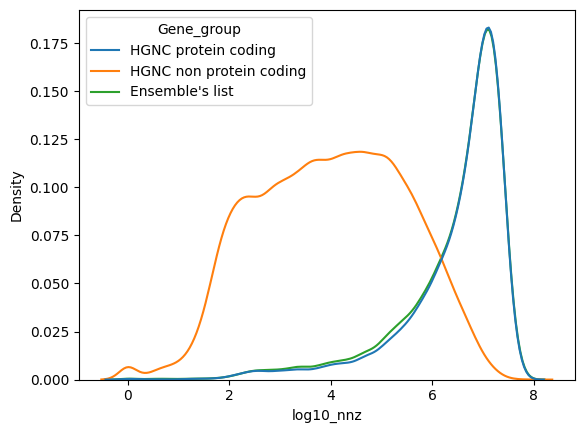

In [30]:
cellxgene_nnz_tab = pd.concat([cellxgene_protein_coding_tab, cellxgene_non_protein_coding, cellxgene_from_ensemble_list])
cellxgene_nnz_tab["log10_nnz"] = np.log10(cellxgene_nnz_tab["nnz"] + 1)
sns.kdeplot(data=cellxgene_nnz_tab, x="log10_nnz", hue="Gene_group")


In [31]:
def prepare_upset_data(dfs, column_name):
    """
    Prepare intersection data for UpSet plot based on a specific column, 
    with boolean indicators corresponding to dataframes (df1, df2, etc.).

    Parameters
    ----------
    dfs (list of pd.DataFrame): A list of dataframes.
    column_name (str): The column on which to calculate intersections.

    Returns
    -------
    pd.Series: A pandas Series in the format required by upsetplot.
    """
    # Convert the specified column in each dataframe to a set
    sets = [set(df[column_name]) for df in dfs]

    # Generate dataframe names ('df1', 'df2', etc.)
    df_names = [f'df{i+1}' for i in range(len(dfs))]

    # Prepare a dictionary to store intersections
    intersection_counts = {}

    # Generate all possible combinations of dataframe indices
    for r in range(1, len(dfs) + 1):
        for comb in combinations(range(len(dfs)), r):
            # Get the intersection of the sets based on the combination of indices
            intersection = set.intersection(*[sets[i] for i in comb])
            # Create a boolean tuple to represent the combination
            key = tuple((i in comb) for i in range(len(dfs)))
            # Store the intersection size in the dictionary
            intersection_counts[key] = len(intersection)
    
    # Convert to pandas Series for upsetplot
    intersection_series = pd.Series(intersection_counts)

    # Rename the index levels to use dataframe names ('df1', 'df2', etc.)
    intersection_series.index.names = df_names

    return intersection_series

set1 = pd.DataFrame({'feature_name': cellxgene_genes_var.feature_name}) 
set2 = pd.DataFrame({'feature_name': hgnc_protein_coding.symbol}) 
set3 = pd.DataFrame({'feature_name': pd.Series(ensemble_df.columns.values)})  

intersection_data = prepare_upset_data([set1, set2, set3], 'feature_name')


In [32]:
intersection_data.index.names = ['cellxgene_genes_var', 'hgnc_protein_coding', 'ensemble_list']

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

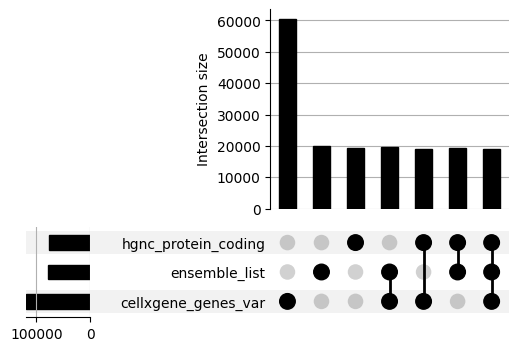

In [33]:
plot(intersection_data)

## Review discrepancies between HGNC and Ensemble's list

In [34]:
hgnc_protein_coding_list = hgnc_protein_coding.symbol
intersection_ensemble_list_and_hgnc_protein = set(hgnc_protein_coding_list) & set(ensemble_list)
print(f""" HGNC protein-coding: {hgnc_protein_coding.shape[0]}
Ensemble's list: {len(ensemble_list)}
Intersection size: {len(intersection_ensemble_list_and_hgnc_protein)}""")


 HGNC protein-coding: 19283
Ensemble's list: 19825
Intersection size: 19186


In [35]:
hgnc_protein_coding_not_in_ensemble_list = {*hgnc_protein_coding_list} - {*ensemble_list}
print(f"""Number of HGNC protein-coding genes that does not appear in Ensemble's list: {len(hgnc_protein_coding_not_in_ensemble_list)}""")

Number of HGNC protein-coding genes that does not appear in Ensemble's list: 97


In [36]:
ensemble_not_in_hgnc_symbol_list = {*ensemble_list} - {*hgnc.symbol}
print(f"""Number of genes in Ensemble's list that that does not appear on the HGNC at all (according to the symbol column): {len(ensemble_not_in_hgnc_symbol_list)}""")

Number of genes in Ensemble's list that that does not appear on the HGNC at all (according to the symbol column): 20


In [37]:
ensemble_in_hgnc_not_protein_coding = {*ensemble_list} - {*hgnc_protein_coding_list} - {*ensemble_not_in_hgnc_symbol_list}
print(f"""Number of genes in Ensemble's list that appear on the HGNC list but NOT as protein-coding genes: {len(ensemble_in_hgnc_not_protein_coding)} """)

Number of genes in Ensemble's list that appear on the HGNC list but NOT as protein-coding genes: 619 


In [38]:
hgnc_protein_coding_symbol_not_in_ensemble = hgnc_protein_coding.loc[hgnc_protein_coding['symbol'].isin(hgnc_protein_coding_not_in_ensemble_list)]
hgnc_protein_coding_prev_symbol_in_ensemble_list = set(hgnc_protein_coding_symbol_not_in_ensemble.prev_symbol) & set(ensemble_not_in_hgnc_symbol_list)
print(f"""There are {len(hgnc_protein_coding_prev_symbol_in_ensemble_list)} genes that their symbol does not appear in Ensemble's list but their previous symbol ('prev_symbol') is""")

hgnc_protein_coding_not_in_ensemble_list = {*hgnc_protein_coding_not_in_ensemble_list} - {*hgnc_protein_coding.loc[hgnc_protein_coding['prev_symbol'].isin(hgnc_protein_coding_prev_symbol_in_ensemble_list)].symbol }

There are 12 genes that their symbol does not appear in Ensemble's list but their previous symbol ('prev_symbol') is


In [39]:
hgnc_protein_coding_alias_symbol_in_ensemble_list = set(hgnc_protein_coding_symbol_not_in_ensemble.alias_symbol) & set(ensemble_not_in_hgnc_symbol_list)
print(f"""We got {len(hgnc_protein_coding_alias_symbol_in_ensemble_list)} protein-coding genes that their previous symbol is in Ensemble's list but not their current symbol. """)

hgnc_protein_coding_not_in_ensemble_list = {*hgnc_protein_coding_not_in_ensemble_list} - {*hgnc_protein_coding.loc[hgnc_protein_coding['alias_symbol'].isin(hgnc_protein_coding_alias_symbol_in_ensemble_list)].symbol }

We got 1 protein-coding genes that their previous symbol is in Ensemble's list but not their current symbol. 


In [40]:
print(f""" We are left with {len(hgnc_protein_coding_not_in_ensemble_list)} protein coding genes to explain. """)

 We are left with 84 protein coding genes to explain. 


Let look on their expression rate on cellxgene:

In [41]:
cellxgene_genes_var.loc[cellxgene_genes_var['feature_name'].isin(hgnc_protein_coding_not_in_ensemble_list)].sort_values('nnz')

,Unnamed: 0,soma_joinid,feature_id,feature_name,feature_length,nnz,n_measured_obs
60474,60474,60474,ENSG00000286025,FAM246C,1719,51,1274370
40200,40200,40200,ENSG00000225997,OR4A8,945,117,4755728
51231,51231,51231,ENSG00000262085,OR1P1,994,123,5696394
60283,60283,60283,ENSG00000285843,SCYGR9,279,126,5323046
37379,37379,37379,ENSG00000213439,OR5AC1,925,129,8040428
33627,33627,33627,ENSG00000176290,OR4K3,947,140,6442342
46350,46350,46350,ENSG00000243641,OR13C7,959,172,7386269
49281,49281,49281,ENSG00000254658,OR8J2,2883,323,11402763
33469,33469,33469,ENSG00000142163,OR1E3,948,390,16643095
10782,10782,10782,ENSG00000163098,BIRC8,1826,430,18314219


In [42]:
C14orf178 = find_rows_with_string(hgnc_protein_coding, "C14orf178")
print(C14orf178.transpose())

                                                          3106
hgnc_id                                             HGNC:26385
symbol                                               C14orf178
name                      chromosome 14 open reading frame 178
locus_group                                protein-coding gene
locus_type                           gene with protein product
status                                                Approved
location                                               14q24.3
location_sortable                                      14q24.3
alias_symbol                                          FLJ25976
alias_name                                                 NaN
prev_symbol                                                NaN
prev_name                                                  NaN
gene_group                                                 NaN
gene_group_id                                              NaN
date_approved_reserved                              200

In [43]:

find_and_print_matched_substring(pd.DataFrame(ensemble_df.columns), list(C14orf178))


No matches found in the dataframe.


In [44]:
NXF5 = find_rows_with_string(hgnc_protein_coding, "NXF5")
find_and_print_matched_substring(pd.DataFrame(ensemble_df.columns), list(NXF5))

No matches found in the dataframe.


## Summary
In the 2024-Aug version of the Ensembl genes only 97 genes are missing, i.e. 97 genes appear in HGNC as protein-coding genes and does not listed in the Ensembl list. 
- Most of those genes do not have previous or alias names and probably will be included in future versions. 
- Other gene names (13 were found) appear on another column than 'symbol' within the HGNC table (e.g., prev_symbol, alias_symbol, etc.). 


On the other side, there are more than 600 genes that appears on the Ensembl list but aren't consider as protein coding genes in HGNC. 
- Those genes may be part of a complex locus group that constitute a larger gene, thus their names are partially aligned.
- 20 Genes from the Ensembl list are completely missing from the HGNC list.